In [1]:
import os

from lungmask import mask
import SimpleITK as sitk

import cv2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MinMaxScaler


In [2]:
dicomdir = 'osic-pulmonary-fibrosis-progression/train/'
patients = []
for root, dirs, files in os.walk(dicomdir):
    patients += dirs

In [3]:
# Load the DICOM series
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(dicomdir + patients[80])
reader.SetFileNames(dicom_names)
image = reader.Execute()

In [4]:
# Apply lung segmentation
segmentation = mask.apply(image)

100%|██████████| 10/10 [00:00<00:00, 672.27it/s]


In [5]:
segmentation.shape

(38, 512, 512)

In [6]:
# Change all to 1 for mask, we don't care about right vs left lung
segmentation[segmentation > 0] = 1

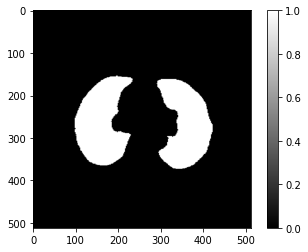

In [7]:
# Visualise the segmentation
imgplot = plt.imshow(segmentation[20,:,:], cmap='gray')
plt.colorbar()

In [8]:
imarray = sitk.GetArrayFromImage(image)

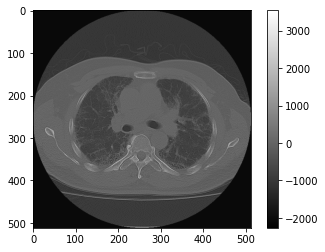

In [9]:
imgplot = plt.imshow(imarray[20], cmap='gray')
plt.colorbar()

In [10]:
masked = imarray.copy()

In [11]:
maked = masked[(segmentation == 0)] = -1500

In [12]:
masked.shape[0]

38

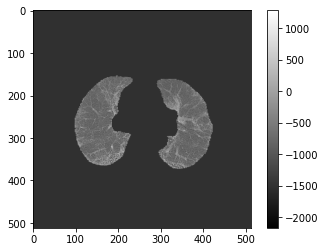

In [13]:
imgplot = plt.imshow(masked[20], cmap='gray')
plt.colorbar()

In [14]:
# Find the borders of the lungs and then crop the empty space

non_empty_rows = []
non_empty_columns = []
for i in range(masked.shape[0]):
    non_empty_rows += np.where(masked[i].max(axis=0) > -1400)[0].tolist()
    non_empty_columns += np.where(masked[i].max(axis=0) > -1400)[0].tolist()
    
cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
cropped = masked[:, cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1]

In [15]:
# Clip the minimum and maximum pixel values

clipped = np.clip(cropped, -1000, 1000).astype('float32')

In [16]:
clipped.dtype

dtype('float32')

In [17]:
# Resize the slices to be 200x200 pixels

imgsize = 200
resized = np.zeros((len(clipped), imgsize, imgsize))

for i in range(len(clipped)):
    img_res = cv2.resize(clipped[i], (imgsize, imgsize), interpolation=cv2.INTER_NEAREST)
    resized[i,:,:] = img_res

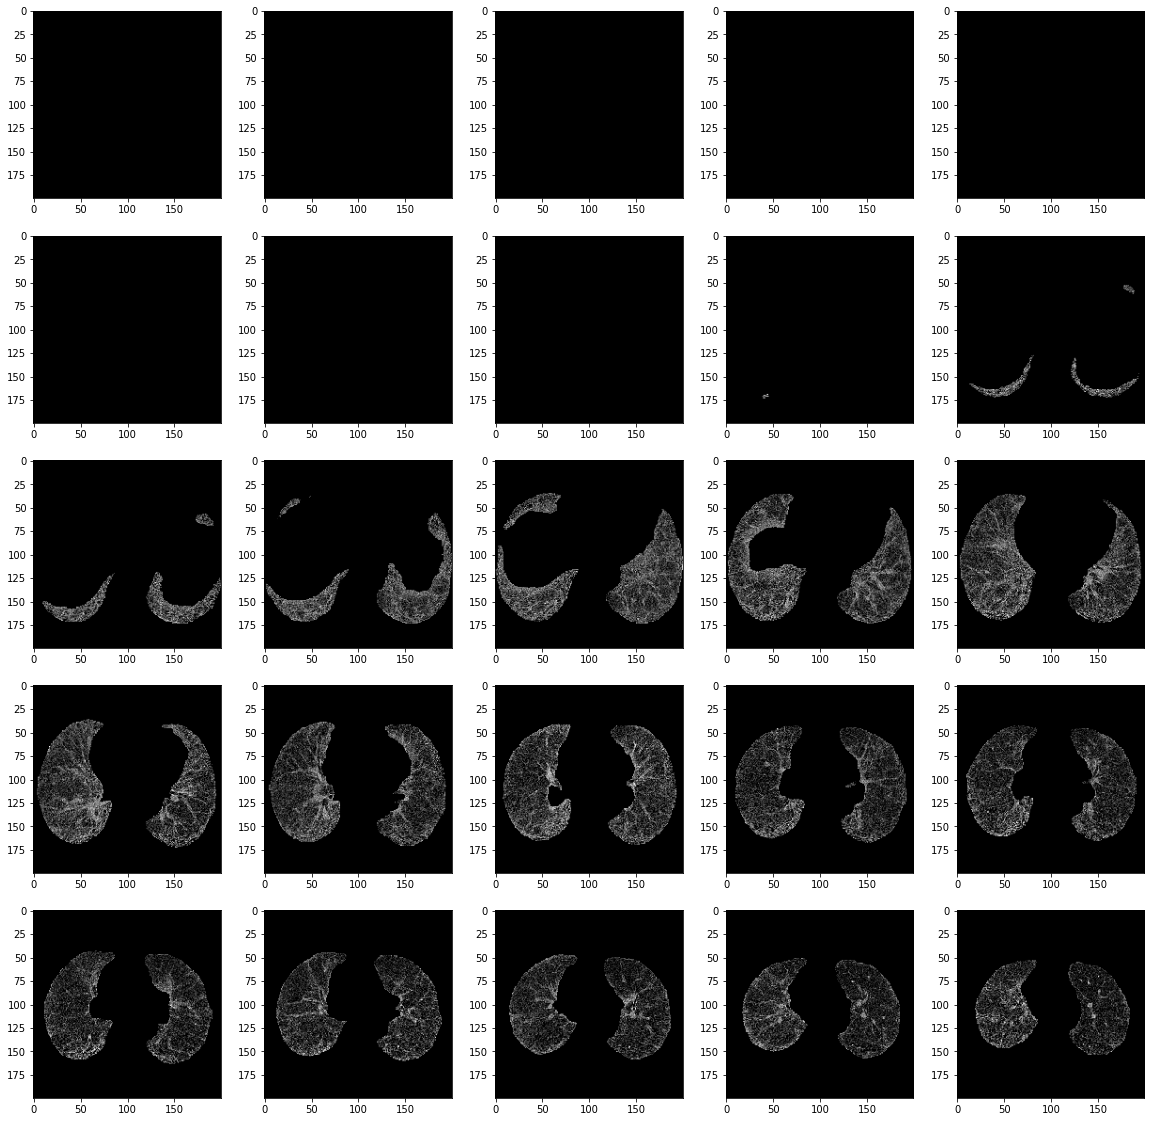

In [18]:
fig = plt.figure(figsize=[20,20])
for i in range(25):
    y = fig.add_subplot(5,5,i+1)
    y.imshow(resized[i], cmap='gray')

In [19]:
# Scale the pixel values to be between -1 and 1

scaled = np.zeros((len(resized), imgsize, imgsize))

scaler = MinMaxScaler()
scaler.set_params(feature_range=(-1,1))
for i in range(len(resized)):
    temp = scaler.fit_transform(resized[i])
    scaled[i,:,:] = temp

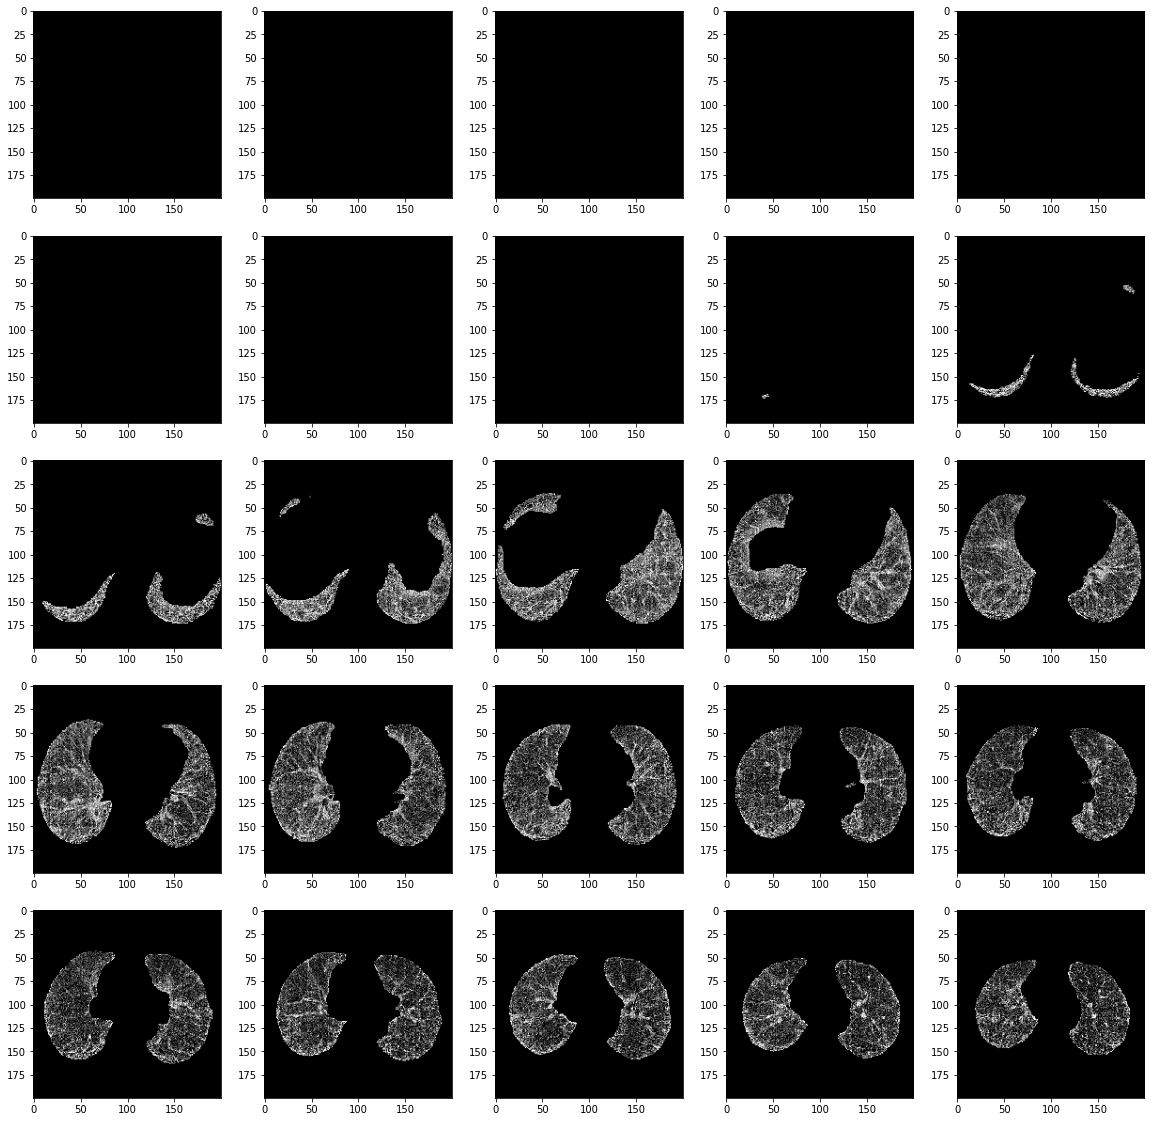

In [20]:
fig = plt.figure(figsize=[20,20])
for i in range(25):
    y = fig.add_subplot(5,5,i+1)
    y.imshow(scaled[i], cmap='gray')

In [21]:
# Drop any slices that have nothing or almost nothing in them
filtered = scaled.copy()
todrop = []

for i in range(len(scaled)):
    if scaled[i].sum() < -38980:
        print("Dropping slice: " + str(i))
        todrop.append(i)

filtered = np.delete(filtered, todrop, axis=0)

Dropping slice: 0
Dropping slice: 1
Dropping slice: 2
Dropping slice: 3
Dropping slice: 4
Dropping slice: 5
Dropping slice: 6
Dropping slice: 7
Dropping slice: 8
Dropping slice: 32
Dropping slice: 33
Dropping slice: 34
Dropping slice: 35
Dropping slice: 36
Dropping slice: 37


IndexError: index 23 is out of bounds for axis 0 with size 23

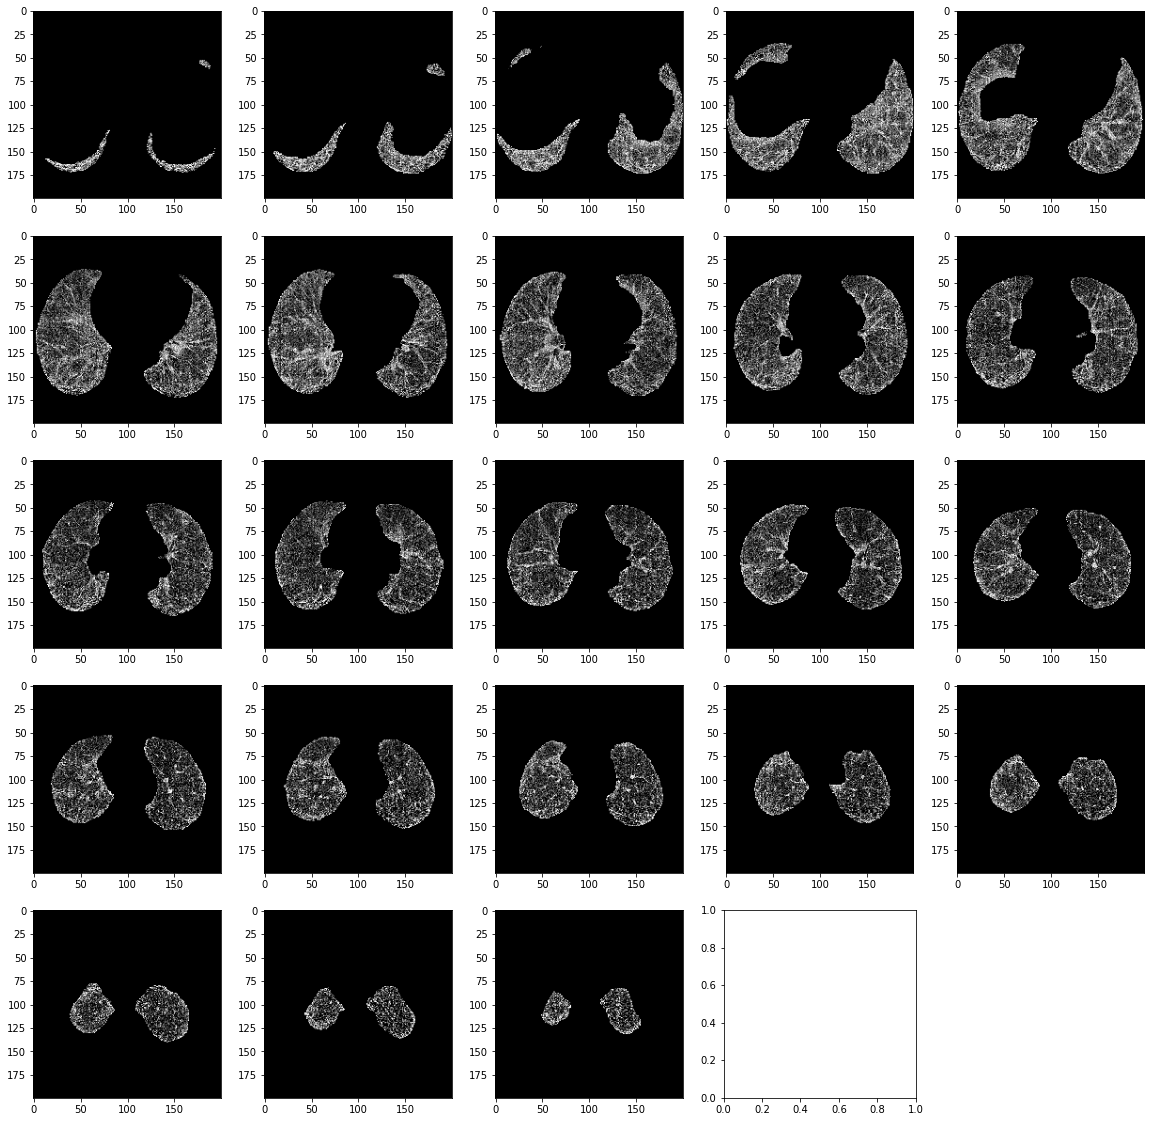

In [22]:
fig = plt.figure(figsize=[20,20])
for i in range(25):
    y = fig.add_subplot(5,5,i+1)
    y.imshow(filtered[i], cmap='gray')

In [ ]:
# TO DO
# Condense many slices into fewer slices